# Hyperopt Experiments

This file contains the code for experiments using Hyperopt on both the classification and regression datasets, as well as the code used to produce the UI components for the tool (basic plots)

In [18]:
# Import required modules
from hyperopt import fmin, tpe, Trials
from hyperopt.hp import quniform, loguniform
from hyperopt.plotting import main_plot_history, main_plot_histogram, main_plot_vars

import time
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, precision_score, recall_score

In [19]:
# Set random seed
RANDOM_SEED = 3

In [20]:
# Function for calculating elapsed time
def print_elapsed_time(start, end):
    elapsed_time = end - start
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    print("Elapsed time: {} minutes, {} seconds".format(minutes, seconds))

## Hospital Readmissions (Classification)

In this section, we run Hyperopt on our classification dataset. To do so, we have to define a space of parameters to try, which is defined below as `space`. Then, we also define a metric we are trying to minimize. Hyperopt is only capable of minimizing functions, but accuracy as a metric is something we want to maximize. To make this possible, we need to have our objective be the NEGATIVE accuracy score. This is different from what we see with Optuna, where we can specify if we want to maximize or minimize.

In [21]:
# Read in Data
readmissions = pd.read_csv('../data/classification/readmissions_clean.csv')

# Split into X and Y
X = readmissions.drop(['readmitted'], axis=1)
y = readmissions.readmitted

# Split X and Y into train-test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=RANDOM_SEED, test_size=0.2)

In [22]:
# Define an objective to minimize
# Since we want to maximize accuracy, we return negative accuracy
def objective(params):
    # Define which parameters we will be training
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    max_features = int(params['max_features'])

    # Train and fit RFC
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
    rf.fit(X_train, y_train)

    # Make and score predictions
    pred=rf.predict(X_test)
    score = accuracy_score(y_test,pred)
    
    return -score

# Define range of parameters to try out (same range as used in Grid Search and Optuna)
space = {
    'n_estimators': quniform('n_estimators', 50, 300, 1),
    'max_depth': quniform('max_depth', 5, 15, 1),
    'max_features': quniform('max_features', 3, 10, 1)
}

In [23]:
# Run and time optimization
start = time.time() 
trials = Trials()                              
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials, rstate=np.random.default_rng(RANDOM_SEED))
end = time.time()

100%|██████████| 100/100 [03:08<00:00,  1.89s/trial, best loss: -0.63] 


We see that the Hyperopt optimization took 3 minutes, 8 seconds:

In [24]:
# Display time elapsed
print_elapsed_time(start,end)

Elapsed time: 3 minutes, 8 seconds


Hyperopt has some plotting functions that let us view how the trials compare to one another:

avg best error: -0.63


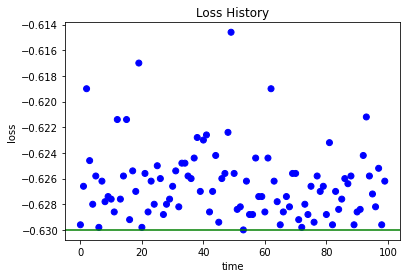

In [25]:
# Plot of loss (y) vs trial number (x)
main_plot_history(trials)

Showing Histogram of 100 jobs


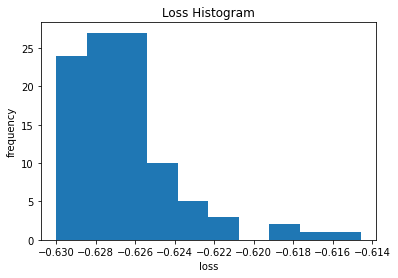

In [26]:
# Histogram of loss values across all 100 trials
main_plot_histogram(trials)

finite loss range -0.63 -0.6146 -1.63


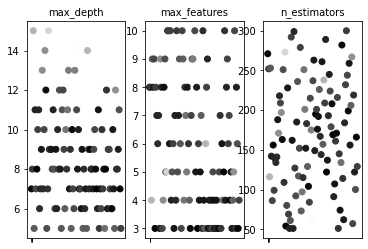

In [27]:
# Not entirely sure what this shows as it is not explained in the Hyperopt documentation
main_plot_vars(trials)

We can also view the optimal parameters that Hyperopt found across 100 trials:

In [28]:
print("Best Hyperparameters: ", best)

Best Hyperparameters:  {'max_depth': 7.0, 'max_features': 3.0, 'n_estimators': 195.0}


We then take these best hyperparameters, and plug them back in to our RFC to get our final metrics:

In [29]:
# Re-fit classifier with optimal parameters
rf = RandomForestClassifier(random_state=RANDOM_SEED, max_depth=best['max_depth'], max_features=int(best['max_features']), n_estimators=int(best['n_estimators']))
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calculate and print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.6286
Precision: 0.628085573230938
Recall: 0.4926850258175559


## Car Emissions Data (Regression)

For regression, we complete similar steps, instead using one of our regression-specific metrics, mean squared error (MSE). To optimize this metric, we want to minimize, so this time we don't have to do any tricks like returning the negative value.

In [30]:
# Read in data
emissions = pd.read_csv("../data/regression/emissions_cleaned.csv")

# Split dataset into X and Y
X = emissions.drop('co2_emissions', axis=1)
y = emissions["co2_emissions"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=RANDOM_SEED, test_size=0.2)

In [31]:
# Define our objective to minimize
def objective(params):
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    max_features = int(params['max_features'])

    # Train and fit RFR
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=RANDOM_SEED)
    rf.fit(X_train, y_train)
    
    # Make and score predictions
    pred=rf.predict(X_test)
    score = mean_squared_error(y_test,pred)

    return score

# Define range of parameters to try out (same range as used for classification testing)
space = {
    'n_estimators': quniform('n_estimators', 50, 300, 1),
    'max_depth': quniform('max_depth', 5, 15, 1),
    'max_features': quniform('max_features', 3, 10, 1)
}


In [32]:
start = time.time()
trials = Trials() 
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials, rstate=np.random.default_rng(RANDOM_SEED))
end = time.time()

100%|██████████| 100/100 [01:02<00:00,  1.60trial/s, best loss: 9.303570702842844]


This time, the optimization took 1 minute, 2 seconds

In [33]:
# Display time elapsed
print_elapsed_time(start,end)

Elapsed time: 1 minutes, 2 seconds


We can again view the graphs produced by Hyperopt:

avg best error: 9.303570702842844


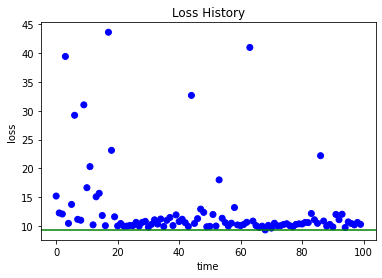

In [34]:
# Plot of loss (y) vs trial number (x)
main_plot_history(trials)

Showing Histogram of 100 jobs


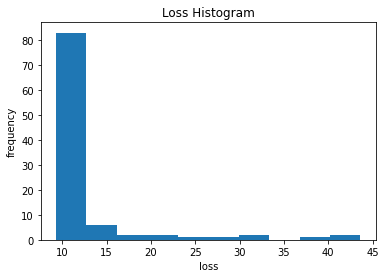

In [35]:
# Histogram of loss values across all 100 trials
main_plot_histogram(trials)

finite loss range 9.303570702842844 43.62361648537094 8.303570702842844


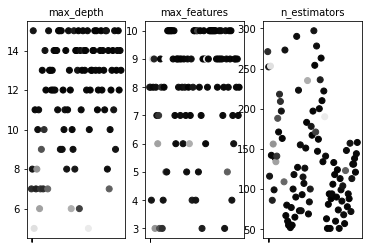

In [36]:
# Not entirely sure what this shows as it is not explained in the Hyperopt documentation
main_plot_vars(trials)

We can then view the best parameters found by Hyperopt:

In [37]:
print("Best Hyperparameters: ", best)

Best Hyperparameters:  {'max_depth': 14.0, 'max_features': 10.0, 'n_estimators': 94.0}


Finally, we take these and plub them back into our model to get our final metrics:

In [56]:
# Re-fit regressor with optimal parameters
rf = RandomForestRegressor(random_state=RANDOM_SEED , max_depth = best['max_depth'], max_features = int(best['max_features']), n_estimators = int(best['n_estimators']))
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [55]:
# Get performance metrics
MSE = -cross_val_score(rf, X_train,y_train, cv=3, scoring='neg_mean_squared_error').mean()
MAE = -cross_val_score(rf, X_train,y_train, cv=3, scoring='neg_mean_absolute_error').mean()
MAPE = -cross_val_score(rf, X_train,y_train, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
Accuracy = cross_val_score(rf, X_train,y_train, cv=3).mean()

print('MSE: ', MSE, ', MAE: ', MAE, ', MAPE: ', MAPE, 'Accuracy: ', Accuracy)

MSE:  9.06894317355322 , MAE:  1.8720278567997244 , MAPE:  0.0075961756651046165 Accuracy:  0.9973607367109811
